In [24]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import pickle

In [25]:
from torch.utils.data.dataset import Dataset
class BreastCancerDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.df = pd.read_csv(root_dir)
        cols_to_drop = ['id']
        self.df = self.df.drop(cols_to_drop, axis=1)
        diag = [1 if entry == 'M' else 0 for entry in self.df.diagnosis]
        self.df.diagnosis = diag
        self.df = self.df.dropna(axis=1)
        self.data = self.df.to_numpy()
    
    def __getitem__(self, i):
        return self.data[i,:]
    
    def __len__(self):
        return self.data.shape[0]

In [26]:
DATA_DIR = "data/breast_cancer_wisconsin.csv"
dataset = BreastCancerDataset(DATA_DIR)
print(len(dataset))
dataset.df.head(5)

569


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Data Visualization

In [27]:
c_list = []
for label in dataset.df.diagnosis:
    if label == 1:
        c_list.append('r')
    else:
        c_list.append('b')

def scatter(df, title, x, y, c):
    fig, ax = plt.subplots()
    ax.scatter(df[x], df[y], c=c, alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    plt.show()

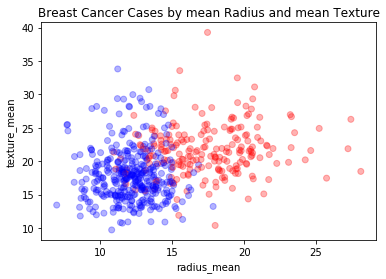

In [28]:
scatter(dataset.df, \
       "Breast Cancer Cases by mean Radius and mean Texture", \
       'radius_mean', 'texture_mean', c_list)

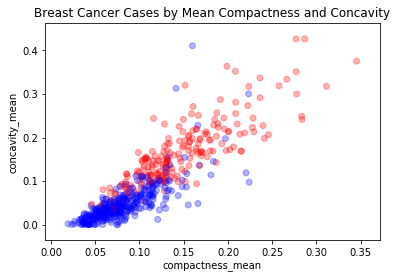

In [29]:
scatter(dataset.df, \
       "Breast Cancer Cases by Mean Compactness and Concavity", \
       'compactness_mean', 'concavity_mean', c_list)

The plots above indicate that these data may quite easily be classified based on the features selected. The data is structurally divided and so one is hopeful that successful inferences can be made.

In [30]:
def generate_batch(batch):
    label = np.array([entry[0] for entry in batch])
    inputs = np.array([entry[1:] for entry in batch])
    return inputs, label

## Models

In [31]:
# SVM
from sklearn.svm import SVC
def train_SVM(x, y, params):
    clf = SVC(**params)
    clf.fit(x, y)
    return clf

def save_sklearn_model(clf, filename):
    if '.sav' in filename:
        path = "models/"+filename
        pickle.dump(clf, open(path, 'wb'))
    else:
        print("Incorrect file extension")

In [32]:
from torch.utils.data import random_split
params = {
    'kernel':'linear',
}
bcw_data = BreastCancerDataset(DATA_DIR)
train_len = int(len(bcw_data) * 0.9) # 10% Split
train_dataset, test_dataset = random_split(bcw_data, \
                                           [train_len, \
                                            len(bcw_data) - train_len
                                           ])
print("train_dataset length: {0} | test_dataset length: {1}".format(len(train_dataset), \
                                                                 len(test_dataset)))

train_dataset length: 512 | test_dataset length: 57


In [33]:
train_x, train_y = generate_batch(train_dataset)
test_x, test_y = generate_batch(test_dataset)

In [34]:
clf = train_SVM(train_x, train_y, params)
save_sklearn_model(clf, 'breast_cancer_svm.sav') # Saves the SVM model

In [35]:
from sklearn.metrics import confusion_matrix
def report(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
#     print(cm)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    
    tpr = tp / (tp+fn)
    tnr = tn / (tn+fp)
    
    precision = tp / (tp+fp)
    fpr = 1 - tnr
    fnr = 1 - tpr
    
    scores = [precision, tpr, tnr, fpr, fnr]
    cols = ['precision', 'tpr', 'tnr', 'fpr', 'fnr']
    for i, col in enumerate(cols):
        print('{}: {:.4}'.format(col, scores[i]))
    return scores, cols

y_pred = clf.predict(train_x)
scores, cols = report(y_pred, train_y)
print("train_score: {:.4}%, test_score: {:.4}%".format(clf.score(train_x, train_y)*100, \
                                                clf.score(test_x, test_y)*100))

precision: 0.9624
tpr: 0.9372
tnr: 0.9782
fpr: 0.02181
fnr: 0.06283
train_score: 96.29%, test_score: 96.49%


accuracy: 9.6e+01%


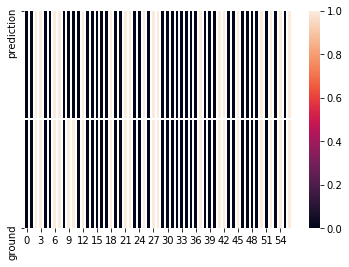

precision: 1.0
tpr: 0.9048
tnr: 1.0
fpr: 0.0
fnr: 0.09524


In [36]:
import seaborn as sns
from sklearn.metrics import accuracy_score
model_path = 'models/breast_cancer_svm.sav'
model = pickle.load(open(model_path, 'rb'))

def make_predictions(testset, model):
    predictions = []
    ground = []
    for row in testset:
        x = row[1:]
        predictions.append(int(model.predict([x])))
        ground.append(row[0])
    return (predictions, ground)

def show_predictions(results):
    hm_data = np.reshape(np.array(results), (2, -1))
    ax = sns.heatmap(hm_data, linewidth=1, yticklabels=['prediction', 'ground'])
    accuracy = accuracy_score(results[1], results[0])
    print('accuracy: {:.2}%'.format(accuracy*100))
    plt.show()

predictions_test, ground_test = make_predictions(test_dataset, model)
show_predictions(make_predictions(test_dataset, model))
scores, cols = report(*make_predictions(test_dataset, model))

As expected, the model perfomed exceedingly well on these test data.